# Car_mentorV4_2 Integra una nueva tool para especificacion coches

Sistema de búsqueda inteligente de coches **USANDO LANGRAPH** y **Tavily**:

- Usa IA generativa (Gemini)
- Realiza búsqueda semántica en BigQuery
- Encuentra coches similares a la consulta del usuario (búsqueda vectorial que permite encontrar coches no solo por - - - coincidencia exacta, sino por similitud semántica.)
- Devuelve resultados relevantes con detalles de los vehículos



Importacion libreria necesarias:

In [1]:

import pandas as pd
import google.cloud.bigquery as bigquery
import os
import unicodedata
import logging
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
import re
from langchain_google_vertexai import ChatVertexAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_community.tools import TavilySearchResults
from langgraph.graph import START, StateGraph , MessagesState
from langgraph.prebuilt import tools_condition , ToolNode
from langchain_core.tools import tool
from IPython.display import Image, display
from dotenv import load_dotenv
import json

# Cargar las variables del archivo .env
load_dotenv()

# Acceso a las variables
google_credentials = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
tavily_hey = os.getenv("TAVILY_API_KEY")
langchain_tracing = os.getenv("LANGSMITH_TRACING")
langchain_endpoint = os.getenv("LANGSMITH_ENDPOINT")
langchain_api_key = os.getenv("LANGSMITH_API_KEY")
langchain_project = os.getenv("LANGSMITH_PROJECT")

print(f"Google Credentials: {google_credentials}")
print(f"Tavily Hey: {tavily_hey}")
print(f"LangChain Tracing: {langchain_tracing}")
print(f"LangChain endpoint: {langchain_endpoint}")
print(f"LangChain Api_Key: {langchain_api_key}")
print(f"LangChain project: {langchain_project}")

if not google_credentials:
    raise ValueError("No se encontró GOOGLE_APPLICATION_CREDENTIALS. Asegúrate de configurar tus credenciales de Google Cloud.")

def normalize_text_sql(text: str) -> str:
    text = text.lower().replace('-', ' ')  # Minúsculas y reemplazo de guiones
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')  # Eliminar acentos
    text = re.sub(r'[^a-z0-9\s.]', '', text)  # Solo letras, números y espacios
    text = re.sub(r'\s+', ' ', text).strip()  # Espacios redundantes
    return text


Google Credentials: /Users/andresrsalamanca/.config/gcloud/application_default_credentials.json
Tavily Hey: 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
LangChain Tracing: true
LangChain endpoint: https://eu.api.smith.langchain.com
LangChain Api_Key: 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
LangChain project: car_mentor


In [2]:
# Crear herramienta Tavily
@tool
def buscar_info_adicional(nombre_coche: str) -> str:
    """Busca información actualizada sobre un modelo específico de coche en sitios web autorizados.

   Args:
       nombre_coche (str): Nombre del modelo de coche para buscar (ej: "BMW 320d 2019")
   
   Returns:
       str: Resultados relevantes encontrados incluyendo reseñas, especificaciones y valoraciones
            de los sitios web configurados.
   
   Example:
       >>> buscar_info_adicional("BMW 320d 2019")
       'El BMW 320d 2019 destaca por su eficiencia...'
   """
    search = TavilySearchResults(
        max_results=4,
        include_domains=[
            "motor.es",
            "motor.com.co",
            "motorpasion.com",
            "coches.net",
            "autobild.es"      
            
        ]
    )
    results = search.invoke(f"{nombre_coche} review specs")
    return results


In [3]:

# Configurar el cliente de BigQuery
client = bigquery.Client(project="driven-strength-449810-t8")

@tool
def buscar_producto_bd(consulta: str, filtros: dict = None):
    """
    Busca productos en la base de datos utilizando una consulta semántica en BigQuery.
    Tu objetivo es proporcionar respuestas precisas para ayudar en la búsqueda en el inventario de coches disponibles.
    
    Args:
        consulta (str): Consulta de texto para buscar productos similares.
    
    Returns:
        list[dict]: Resultados formateados como una lista de diccionarios con detalles de los productos más relevantes.
    """
    
    if not consulta.strip():
        raise ValueError("La consulta no puede estar vacía.")

    # Normalizar la consulta para que coincida con el formato de los embeddings.
    consulta_normalizada = normalize_text_sql(consulta)
    logging.debug(f"Consulta normalizada: {consulta_normalizada}")
    
    try:
        base_query = """
        WITH resultados_vector AS (
            SELECT 
                base.content AS nombre_coche,
                base.mecanica,
                base.price,
                base.KM,
                base.year,
                base.image_url,
                search_result.distance
            FROM VECTOR_SEARCH(
                TABLE `web_cars.coches_embeddingsV1`,
                'ml_generate_embedding_result',
                (SELECT * FROM ML.GENERATE_EMBEDDING(
                    MODEL `driven-strength-449810-t8.mymodel.modelembedding`,
                    (SELECT @consulta AS content),
                    STRUCT(TRUE AS flatten_json_output, 'SEMANTIC_SIMILARITY' AS task_type, 768 AS output_dimensionality)
                )),
                'ml_generate_embedding_result',
                top_k => 6
            ) AS search_result
        )
        SELECT * FROM resultados_vector
        WHERE 1=1
        """
        
        # Inicializar lista de condiciones y parámetros
        query_conditions = []
        # Usamos la consulta normalizada para la generación del embedding
        query_parameters = [bigquery.ScalarQueryParameter("consulta", "STRING", consulta_normalizada)]
        
        # Agregar condiciones dinámicamente según los filtros proporcionados
        if filtros:
            if 'precio_max' in filtros:
                query_conditions.append("price <= @precio_max")
                query_parameters.append(bigquery.ScalarQueryParameter("precio_max", "INT64", filtros["precio_max"]))
            if 'precio_min' in filtros:
                query_conditions.append("price >= @precio_min")
                query_parameters.append(bigquery.ScalarQueryParameter("precio_min", "INT64", filtros["precio_min"]))
            if 'year_min' in filtros:
                query_conditions.append("year >= @year_min")
                query_parameters.append(bigquery.ScalarQueryParameter("year_min", "INT64", filtros["year_min"]))
            if 'km_max' in filtros:
                query_conditions.append("KM <= @km_max")
                query_parameters.append(bigquery.ScalarQueryParameter("km_max", "INT64", filtros["km_max"]))

        # Si hay filtros, agregarlos a la consulta
        # if query_conditions:
        #     base_query += " AND " + " AND ".join(query_conditions)
        if query_conditions:
            base_query += " " + " AND ".join(query_conditions)


        logging.debug(f"Consulta SQL generada: {base_query}")
        logging.debug(f"Parámetros de consulta: {query_parameters}")

        # Ejecutar la consulta
        query_job = client.query(
            base_query, 
            job_config=bigquery.QueryJobConfig(query_parameters=query_parameters)
        )
        results = query_job.result().to_dataframe()
        # Ordenar los resultados por similitud
        if not results.empty:
            results = results.sort_values(by="distance", ascending=True)

        if results.empty:
            return [{"error": "No se encontraron resultados para la consulta y los filtros aplicados."}]
            
        formatted_results = [
            {
                "nombre_coche": row["nombre_coche"],
                "mecanica": row["mecanica"],
                "precio": row["price"],
                "kilometros": row["KM"],
                "año": row["year"],
                "imagen": row["image_url"],
                "similitud": round(row["distance"], 2)
            }
            for _, row in results.iterrows()
        ]
        return formatted_results

    except Exception as e:
        logging.error(f"Error al ejecutar la consulta: {e}", exc_info=True)
        return [{"error": "No se pudieron encontrar resultados."}]

# Definir herramientas
# tools = [buscar_producto_bd]

llm = ChatVertexAI(
    model_name="gemini-1.5-flash-002",
    project="driven-strength-449810-t8",
    location="europe-west1",
    temperature=0.3,
    max_output_tokens=700
)

# Actualizar lista de herramientas
tools = [buscar_producto_bd, buscar_info_adicional]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)


2025-02-20 15:34:00,021 - DEBUG - Checking /Users/andresrsalamanca/.config/gcloud/application_default_credentials.json for explicit credentials as part of auth process...
2025-02-20 15:34:00,021 - DEBUG - Explicit credentials path /Users/andresrsalamanca/.config/gcloud/application_default_credentials.json is the same as Cloud SDK credentials path, fall back to Cloud SDK credentials flow...
2025-02-20 15:34:00,022 - DEBUG - Checking Cloud SDK credentials as part of auth process...


In [4]:

sys_msg = SystemMessage(content="""Eres Mentor, un util y experto en la busqueda de coches.
INSTRUCCIONES IMPORTANTES:
**Antes de hacer una búsqueda en la base de datos, analiza la consulta y extrae solo la información clave.**  
   - Si el usuario menciona un coche, filtra la consulta para obtener solo **la marca, modelo, versión, tipo de motorización y año**.
   - **No incluyas frases completas del usuario como búsqueda.**  
   - **No pases palabras como "quiero", "busco", "auto", "coche", "modelo", "año" si no son parte del nombre oficial del coche.**
   - **Ejemplo:**  
     - Entrada: `"quiero coche bmw serie 1 120d hibrido año 2024"`  
     - **Consulta que debes generar:** `"bmw serie 1 120d hibrido 2024"`

**Definiendo Preferencias**
   - Para dar recomendaciones acertadas, puedes pedir al usuario que proporcione detalles sobre lo que busca:
     • ¿Tienes una **marca** preferida?
     • ¿Cuál es tu **presupuesto máximo**? (Opcional)
     • ¿Te importa el **kilometraje máximo**? (Opcional)
     • ¿Qué **años de antigüedad** son aceptables? (Opcional)

**Presentación de Resultados**
    - Aplica los filtros pero muestra también alguna alternativa fuera de los filtros si es muy relevante
    Usa este formato para cada coche encontrado: 
    ### [Modelo]
    ![Imagen del vehículo]([url_imagen])
     - **Precio:** [precio]€
     - **Kilómetros:** [km] km
     - **Mecánica:** [tipo]
     - **Año:** [year]
     - **Similitud con tu búsqueda:** [score]
 
** Ajustes**
   - Si no encuentras lo que buscas, dime si quieres:
   - Aumentar el **presupuesto** para ver modelos más recientes.
   - Ampliar el **kilometraje permitido** para más opciones.
   - Incluir **otros años** para expandir la búsqueda.
   
**Información Adicional**
   -usa la herramienta `buscar_info_adicional` para obtener información actualizada sobre un modelo específico de coche.
   - **Ejemplo:** `buscar_info_adicional("que caracteristicas tiene el BMW 320d 2019")`
""")
# - También puedo **comparar dos coches** si tienes modelos específicos en mente.
def assistant(state: MessagesState):
    """
    Función principal del asistente invocando una búsqueda.
    """
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


#    user_input = state["messages"][-1].content  # Último mensaje del usuario
# if detect_comparison_intent(user_input):
#         car1, car2 = extract_car_models_llm(user_input)
#         if car1 and car2:
#             car1_data, car2_data = obtener_datos_comparacion(car1, car2)
#             return {"messages": [comparar_coches_llm(car1_data, car2_data)]}
#         else:
#             return {"messages": ["No pude identificar claramente los coches a comparar. ¿Podrías mencionarlos nuevamente?"]}


2025-02-20 15:34:11,348 - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-02-20 15:34:11,891 - DEBUG - https://mermaid.ink:443 "GET /img/JSV7aW5pdDogeydmbG93Y2hhcnQnOiB7J2N1cnZlJzogJ2xpbmVhcid9fX0lJQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFzc2lzdGFudChhc3Npc3RhbnQpCgl0b29scyh0b29scykKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IGFzc2lzdGFudDsKCXRvb2xzIC0tPiBhc3Npc3RhbnQ7Cglhc3Npc3RhbnQgLS4tPiB0b29sczsKCWFzc2lzdGFudCAtLi0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/11" 200 9185


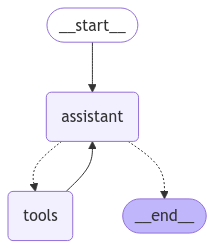

In [5]:
memory = MemorySaver()

# Graph
graph = StateGraph(MessagesState)

# Define nodes: these do the work
graph.add_node("assistant", assistant)
graph.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
graph.add_edge(START, "assistant")
graph.add_conditional_edges(
    "assistant",
    lambda state: logging.debug(f"tools_condition evalúa: {tools_condition(state)}") or tools_condition(state)
)
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
graph.add_edge("tools", "assistant")
graph = graph.compile(checkpointer=memory)
# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Specify an input
input_message = HumanMessage(content="quiero coche bmw serie 1 120d hibrido año 2024")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

2025-02-20 15:34:16,340 - DEBUG - Starting new HTTPS connection (1): eu.api.smith.langchain.com:443
2025-02-20 15:34:16,444 - DEBUG - https://eu.api.smith.langchain.com:443 "GET /info HTTP/11" 200 672
2025-02-20 15:34:16,556 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:34:17,103 - DEBUG - Starting new HTTPS connection (1): oauth2.googleapis.com:443
2025-02-20 15:34:17,234 - DEBUG - https://oauth2.googleapis.com:443 "POST /token HTTP/11" 200 None
2025-02-20 15:34:18,101 - DEBUG - tools_condition evalúa: __end__


================================ Human Message =================================

quiero coche bmw serie 1 120d hibrido año 2024
================================== Ai Message ==================================

Para poder ayudarte a buscar el BMW Serie 1 120d híbrido del año 2024, necesito precisar algunos detalles.  ¿Podrías indicarme tu presupuesto máximo?  También, ¿qué kilometraje máximo te interesaría?


2025-02-20 15:34:18,213 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:34:23,327 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:34:24,057 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:34:28,063 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:34:33,573 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:35:28,035 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:35:28,994 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:36:35,701 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2025-02-20 15:36:36,459 - DEBUG - https://eu.api.smith.langchain.com:443 "POST /runs/multipart HTTP/11" 202 34
2

In [7]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Specify an input
input_message = HumanMessage(content="kilometraje 50.000 y presupuesto no importa, muestrame todas las opciones")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

2025-02-20 15:34:23,944 - DEBUG - tools_condition evalúa: tools
2025-02-20 15:34:23,949 - DEBUG - Consulta normalizada: bmw serie 1 120d hibrido 2024
2025-02-20 15:34:23,950 - DEBUG - Consulta SQL generada: 
        WITH resultados_vector AS (
            SELECT 
                base.content AS nombre_coche,
                base.mecanica,
                base.price,
                base.KM,
                base.year,
                base.image_url,
                search_result.distance
            FROM VECTOR_SEARCH(
                TABLE `web_cars.coches_embeddingsV1`,
                'ml_generate_embedding_result',
                (SELECT * FROM ML.GENERATE_EMBEDDING(
                    MODEL `driven-strength-449810-t8.mymodel.modelembedding`,
                    (SELECT @consulta AS content),
                    STRUCT(TRUE AS flatten_json_output, 'SEMANTIC_SIMILARITY' AS task_type, 768 AS output_dimensionality)
                )),
                'ml_generate_embedding_result',
 

================================ Human Message =================================

quiero coche bmw serie 1 120d hibrido año 2024
================================== Ai Message ==================================

Para poder ayudarte a buscar el BMW Serie 1 120d híbrido del año 2024, necesito precisar algunos detalles.  ¿Podrías indicarme tu presupuesto máximo?  También, ¿qué kilometraje máximo te interesaría?
================================ Human Message =================================

kilometraje 50.000 y presupuesto no importa, muestrame todas las opciones
================================== Ai Message ==================================
Tool Calls:
  buscar_producto_bd (b2c6ac6b-fe16-489a-9bec-d946569c142c)
 Call ID: b2c6ac6b-fe16-489a-9bec-d946569c142c
  Args:
    consulta: bmw serie 1 120d hibrido 2024
    filtros: {'kilometraje_maximo': 50000.0}
================================= Tool Message =================================
Name: buscar_producto_bd

[{"nombre_coche": "bmw serie 

In [8]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Specify an input
input_message = HumanMessage(content="podrias darme las caracteristicas del bmw serie 1 118i 2024 diesel")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

2025-02-20 15:35:28,886 - DEBUG - tools_condition evalúa: __end__


================================ Human Message =================================

quiero coche bmw serie 1 120d hibrido año 2024
================================== Ai Message ==================================

Para poder ayudarte a buscar el BMW Serie 1 120d híbrido del año 2024, necesito precisar algunos detalles.  ¿Podrías indicarme tu presupuesto máximo?  También, ¿qué kilometraje máximo te interesaría?
================================ Human Message =================================

kilometraje 50.000 y presupuesto no importa, muestrame todas las opciones
================================== Ai Message ==================================
Tool Calls:
  buscar_producto_bd (b2c6ac6b-fe16-489a-9bec-d946569c142c)
 Call ID: b2c6ac6b-fe16-489a-9bec-d946569c142c
  Args:
    consulta: bmw serie 1 120d hibrido 2024
    filtros: {'kilometraje_maximo': 50000.0}
================================= Tool Message =================================
Name: buscar_producto_bd

[{"nombre_coche": "bmw serie 

In [9]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Specify an input
input_message = HumanMessage(content="si, dame las caracteristicas del El 118i a gasolina")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

2025-02-20 15:36:36,344 - DEBUG - tools_condition evalúa: tools
2025-02-20 15:36:36,363 - DEBUG - Starting new HTTPS connection (1): api.tavily.com:443
2025-02-20 15:36:45,558 - DEBUG - https://api.tavily.com:443 "POST /search HTTP/11" 200 2136
2025-02-20 15:36:46,691 - DEBUG - tools_condition evalúa: __end__


================================ Human Message =================================

quiero coche bmw serie 1 120d hibrido año 2024
================================== Ai Message ==================================

Para poder ayudarte a buscar el BMW Serie 1 120d híbrido del año 2024, necesito precisar algunos detalles.  ¿Podrías indicarme tu presupuesto máximo?  También, ¿qué kilometraje máximo te interesaría?
================================ Human Message =================================

kilometraje 50.000 y presupuesto no importa, muestrame todas las opciones
================================== Ai Message ==================================
Tool Calls:
  buscar_producto_bd (b2c6ac6b-fe16-489a-9bec-d946569c142c)
 Call ID: b2c6ac6b-fe16-489a-9bec-d946569c142c
  Args:
    consulta: bmw serie 1 120d hibrido 2024
    filtros: {'kilometraje_maximo': 50000.0}
================================= Tool Message =================================
Name: buscar_producto_bd

[{"nombre_coche": "bmw serie 

In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Specify an input
input_message = HumanMessage(content="quiero un coche kia sportage a gasolina, puede ser año 2011 a 2020 y no importa el kilometraje")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

In [ ]:
# Start conversation
config = {"configurable": {"thread_id": "2"}}

# Specify an input
input_message = HumanMessage(content="maximo 25.000 euros")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "3"}}

# Specify an input
input_message = HumanMessage(content="Mentor quiero un coche familiar, me podrias recomendar alguno?")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "3"}}

# Specify an input
input_message = HumanMessage(content="segun tu conocimiento que me recomiendas?")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "3"}}

# Specify an input
input_message = HumanMessage(content="pues SUV estaria bien y presupuesto hasta  12.000")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "3"}}

# Specify an input
input_message = HumanMessage(content="diesel o gasolina esta bien")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()

In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "3"}}

# Specify an input
input_message = HumanMessage(content="vale maximo 10 años")
output = graph.invoke({"messages": input_message}, config)

# Mostrar los mensajes resultantes del primer paso
for m in output["messages"]:
    m.pretty_print()